In [35]:
# basics
import pandas as pd
import numpy as np

# matplotlib
import matplotlib.pyplot as plt


from funcs.rotation import (get_period_get_amplitude, 
                            rotation_period_uncertainties_mcmc)

# data management
import time as Timestamp
tstamp = Timestamp.strftime("%d_%m_%Y", Timestamp.localtime())

import os
CWD = "/".join(os.getcwd().split("/")[:-2])

import lightkurve as lk


import matplotlib 
matplotlib.rc('xtick', labelsize=14) 
matplotlib.rc('ytick', labelsize=14) 

font = {'family' : 'courier',
        'weight' : 'normal',
        'size'   : 14}

matplotlib.rc('font', **font)

from matplotlib.lines import Line2D

In [46]:
from funcs.detrend import custom_detrending, estimate_detrended_noise
from altaipony.flarelc import FlareLightCurve

from altaipony.utils import sigma_clip


def plot_phase_folded_lightcurve(ax12, row, plural=""):
    ax2, ax = ax12
    nlcs = {"277" : 1, "449": 3, "237" : 2, "452":1}
    x = str(row.ID)[:3]

    res = lk.search_lightcurvefile(f"TIC {row.ID:.0f}")[:nlcs[x]]
    
    sectors = list(res.table["sequence_number"].data.data.astype(str))
    if len(sectors) > 1:
        plural = "s"
    
    s = ", ".join(sectors)

    flcs = res.download_all()

    FLC = flcs.PDCSAP_FLUX.stitch()

    
    # Get Periodogram 
    p = FLC.remove_nans().to_periodogram()
    ax2.plot(p.period * 24., p.power, c="blue")
    
    
    # define FlareLightCurve for flare search and masking
    FLC = FlareLightCurve(time=FLC.time, flux=FLC.flux, flux_err=FLC.flux_err, campaign=FLC.sector)

    FLC = FLC[(np.isfinite(FLC.time)) & (np.isfinite(FLC.flux)) & (np.isfinite(FLC.flux_err))]

    # detrend light curve
    FLCd = custom_detrending(FLC)

    # mask outliers
    mask = sigma_clip(FLCd.detrended_flux)

    # mask flare
    FLC.flux[(FLC.time > 1331.2) & (FLC.time < 1332.6)] = np.nan
    FLC.flux[(FLC.time > 1641.3) & (FLC.time < 1642.6)] = np.nan
    FLC.flux[(FLC.time > 1493.7) & (FLC.time < 1494.5)] = np.nan


    # Mask the flares:
    FLC.flux[~mask] = np.nan

    #
    total_hours_observed = len(FLC.flux) / 30. 
    number_rotations_observed = total_hours_observed / (row.Prot_d * 24.)
    rotstring = r"$n_{rot}=$" + f"{number_rotations_observed:.0f}"
    
    # fold the masked lightcurve with previously derived rotation period
    folded = FLC.fold(period=row.Prot_d, t0=FLC.time[0], )


    # plot folded lightcurve
    ax.scatter(folded.time, folded.flux / np.nanmedian(folded.flux), 

               c="grey", alpha=.2,s=5 )

    t = folded.time
    p = pd.Series(folded.flux).rolling(800, min_periods=400, center=True).median().values / np.nanmedian(folded.flux)

    ax.plot(t, p, c="k", linewidth=3)

    legend_elements = [Line2D([0], [0], marker='o', color='w', 
                       label=f"TIC {row.ID:.0f} (Sector{plural} {s}; " +
                             r" $P_{rot}=$ " + 
                             f"{row.Prot_d*24.:.2f} h; {rotstring})",
                       markerfacecolor='w', markersize=8)
                      ]

    ax.legend(handles=legend_elements, fontsize=14, frameon=False, loc=1)
    
    
    legend_elements = [Line2D([0,0], [0,0], marker='o', color='w', 
                       label=f"TIC {row.ID:.0f}",
                       markerfacecolor='w', markersize=0.1)
                      ]

    ax2.legend(handles=legend_elements, fontsize=14, frameon=False, loc=2)

In [47]:
rot = pd.read_csv(f"{CWD}/analysis/results/mcmc/rotation/mcmc_rotation_output_propagated.csv")

Found cached file /home/ekaterina/.lightkurve-cache/mastDownload/TESS/tess2019140104343-s0012-0000000277539431-0144-s/tess2019140104343-s0012-0000000277539431-0144-s_lc.fits with expected size 2041920.
5% (1015/20119) of the cadences will be ignored due to the quality mask (quality_bitmask=175).
5% (1015/20119) of the cadences will be ignored due to the quality mask (quality_bitmask=175).
/home/ekaterina/Documents/000_envs/forallpurposes/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1113: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


0.06271800000001804 4.255943000000002 1.3055460000000494 1.3142139999999927 0.7568339999999125 0.7940360000000055 8.48929099999998


/home/ekaterina/Documents/000_envs/forallpurposes/lib/python3.6/site-packages/ipykernel_launcher.py:26: ResourceWarning: unclosed file <_io.FileIO name='/home/ekaterina/.lightkurve-cache/mastDownload/TESS/tess2019140104343-s0012-0000000277539431-0144-s/tess2019140104343-s0012-0000000277539431-0144-s_lc.fits' mode='rb' closefd=True>
Found cached file /home/ekaterina/.lightkurve-cache/mastDownload/TESS/tess2019006130736-s0007-0000000452922110-0131-s/tess2019006130736-s0007-0000000452922110-0131-s_lc.fits with expected size 1791360.
7% (1250/17612) of the cadences will be ignored due to the quality mask (quality_bitmask=175).
7% (1250/17612) of the cadences will be ignored due to the quality mask (quality_bitmask=175).
/home/ekaterina/Documents/000_envs/forallpurposes/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1113: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


0.05646200000001045 4.071207999999956 1.187063999999964 1.2583250000000135 1.1860309999999572 1.1776100000000724 8.936699999999973


/home/ekaterina/Documents/000_envs/forallpurposes/lib/python3.6/site-packages/ipykernel_launcher.py:26: ResourceWarning: unclosed file <_io.FileIO name='/home/ekaterina/.lightkurve-cache/mastDownload/TESS/tess2019006130736-s0007-0000000452922110-0131-s/tess2019006130736-s0007-0000000452922110-0131-s_lc.fits' mode='rb' closefd=True>
Found cached file /home/ekaterina/.lightkurve-cache/mastDownload/TESS/tess2019032160000-s0008-0000000044984200-0136-s/tess2019032160000-s0008-0000000044984200-0136-s_lc.fits with expected size 1805760.
11% (1987/17755) of the cadences will be ignored due to the quality mask (quality_bitmask=175).
11% (1987/17755) of the cadences will be ignored due to the quality mask (quality_bitmask=175).
Found cached file /home/ekaterina/.lightkurve-cache/mastDownload/TESS/tess2019058134432-s0009-0000000044984200-0139-s/tess2019058134432-s0009-0000000044984200-0139-s_lc.fits with expected size 1848960.
5% (930/18187) of the cadences will be ignored due to the quality mask

0.2923929999999473 8.730322999999999 3.322024000000056 3.276504999999929 3.2677750000000287 3.420808999999963 22.309828999999922


/home/ekaterina/Documents/000_envs/forallpurposes/lib/python3.6/site-packages/ipykernel_launcher.py:26: ResourceWarning: unclosed file <_io.FileIO name='/home/ekaterina/.lightkurve-cache/mastDownload/TESS/tess2019085135100-s0010-0000000044984200-0140-s/tess2019085135100-s0010-0000000044984200-0140-s_lc.fits' mode='rb' closefd=True>
/home/ekaterina/Documents/000_envs/forallpurposes/lib/python3.6/site-packages/ipykernel_launcher.py:26: ResourceWarning: unclosed file <_io.FileIO name='/home/ekaterina/.lightkurve-cache/mastDownload/TESS/tess2019058134432-s0009-0000000044984200-0139-s/tess2019058134432-s0009-0000000044984200-0139-s_lc.fits' mode='rb' closefd=True>
/home/ekaterina/Documents/000_envs/forallpurposes/lib/python3.6/site-packages/ipykernel_launcher.py:26: ResourceWarning: unclosed file <_io.FileIO name='/home/ekaterina/.lightkurve-cache/mastDownload/TESS/tess2019032160000-s0008-0000000044984200-0136-s/tess2019032160000-s0008-0000000044984200-0136-s_lc.fits' mode='rb' closefd=True

0.10564399999998386 7.356363000000101 2.5713879999999563 2.51281199999994 2.5631630000000314 2.5496709999999894 17.659041000000002


/home/ekaterina/Documents/000_envs/forallpurposes/lib/python3.6/site-packages/ipykernel_launcher.py:26: ResourceWarning: unclosed file <_io.FileIO name='/home/ekaterina/.lightkurve-cache/mastDownload/TESS/tess2018234235059-s0002-0000000237880881-0121-s/tess2018234235059-s0002-0000000237880881-0121-s_lc.fits' mode='rb' closefd=True>
/home/ekaterina/Documents/000_envs/forallpurposes/lib/python3.6/site-packages/ipykernel_launcher.py:26: ResourceWarning: unclosed file <_io.FileIO name='/home/ekaterina/.lightkurve-cache/mastDownload/TESS/tess2018206045859-s0001-0000000237880881-0120-s/tess2018206045859-s0001-0000000237880881-0120-s_lc.fits' mode='rb' closefd=True>


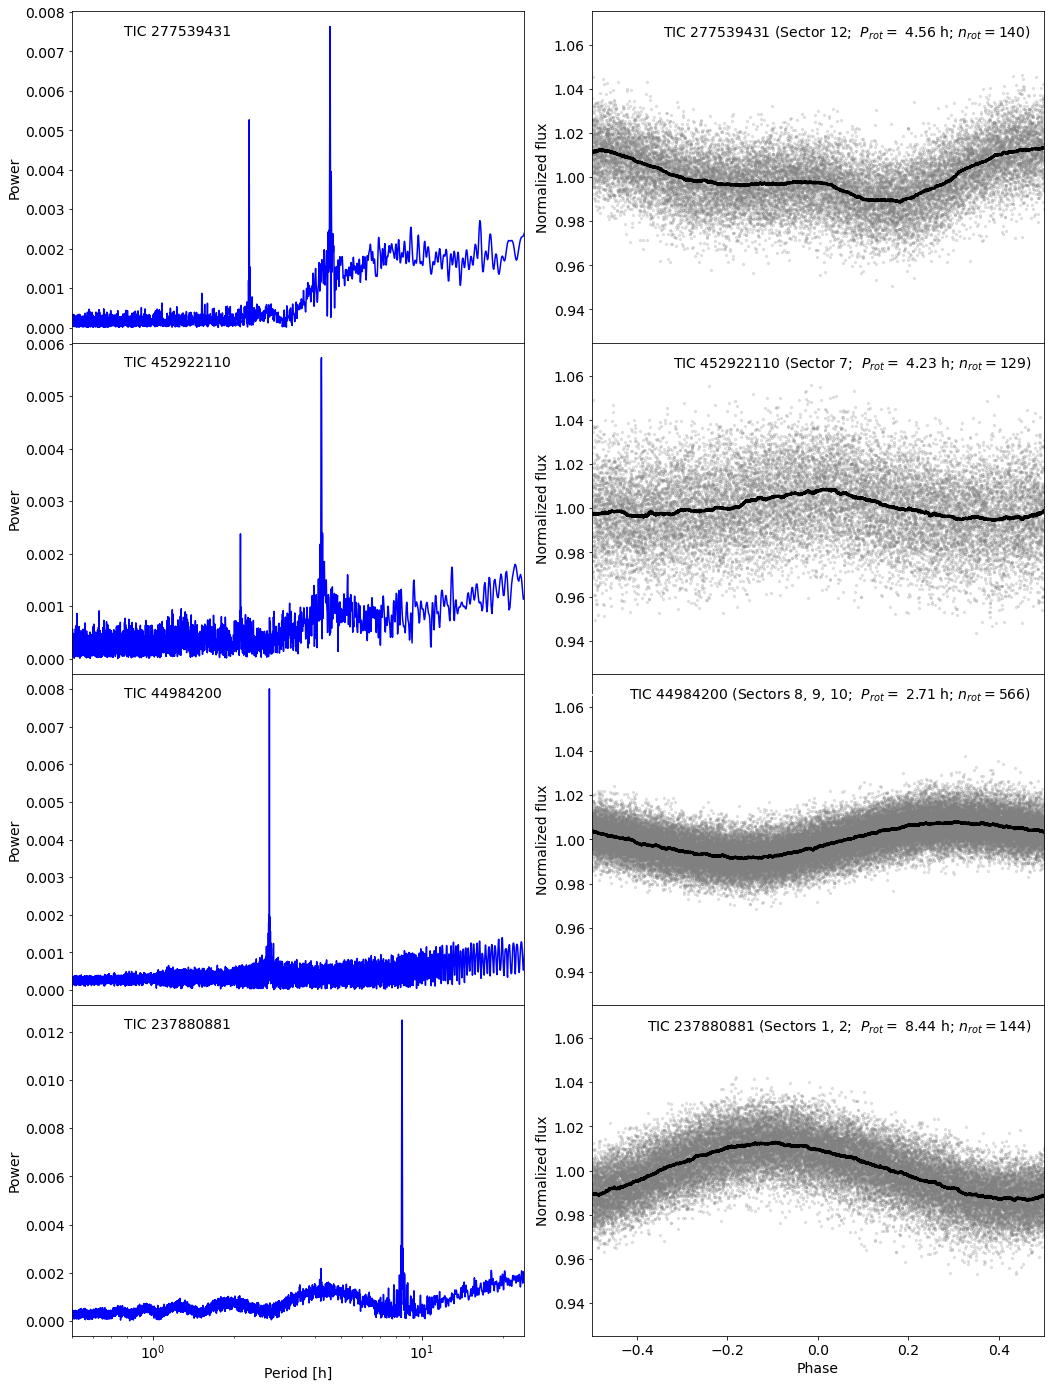

In [48]:
%matplotlib inline
fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(15,20))
# axes = [i for ax in axes for i in ax]


plt.subplots_adjust(left=0.08, bottom=0.04, right=.98, top=.96, hspace=0, wspace=0.15)


for axl, axr in axes[:-1]:
    axl.xaxis.set_visible(False)
    axr.xaxis.set_visible(False)

for axl, axr in axes:
    axr.set_ylabel(r"Normalized flux",fontsize=14)
    axl.set_ylabel(r"Power",fontsize=14)
    
for i in [2,3]:
    axes[-1][1].set_xlabel(f"Phase",fontsize=14)
    axes[-1][0].set_xlabel(f"Period [h]",fontsize=14)

IDs = ["277", "452", "449", "237"]
for id_, ax12 in list(zip(IDs, axes)):
    ax1, ax2 = ax12
    ids = rot.ID.astype(int).astype(str).apply(lambda x: x[:3])
    row = rot[ids == id_].iloc[0]
    plot_phase_folded_lightcurve(ax12, row)

    ax2.set_ylim(.925,1.075)
    ax2.set_xlim(-0.5,0.5)
    ax1.set_xlim(.5,24)
    ax1.set_xscale("log")

# axes[2].set_yticklabels(list(axes[2].get_yticklabels())[:-1])

plt.savefig(f"../plots/rotation/phase_curve_total2.png", dpi=200)
plt.savefig('/home/ekaterina/Documents/002_writing/multiperiod-flares-draft-mnras/figures/mnras_phase_folded_periodogram.png',
            dpi=200)

# Backlog

In [ ]:
%matplotlib inline
fig, axes = plt.subplots(nrows=len(flcs), ncols=1, figsize=(9,len(flcs)*5), sharex=True, sharey=True)
plt.subplots_adjust(hspace=0)


means=[]
# colors = ["black", "grey", "blue",]
for ax, flc in list(zip(axes, flcs)):
    
    # get PDC treated light curve
    #flc = flc.get_lightcurve("PDCSAP_FLUX")
    
    # define FlareLightCurve for flare search and masking
    flc = FlareLightCurve(time=flc.time, flux=flc.flux, flux_err=flc.flux_err, campaign=flc.sector)
    
    flc = flc[(np.isfinite(flc.time)) & (np.isfinite(flc.flux)) & (np.isfinite(flc.flux_err))]

    # detrend light curve
    flcd = custom_detrending(flc)

    # mask outliers
    mask = sigma_clip(flcd.detrended_flux)
    
    # mask flare
    flc.flux[(flc.time > 1331.2) & (flc.time < 1332.6)] = np.nan
    
    # Mask the flares:
    flc.flux[~mask] = np.nan
    
    # fold the masked lightcurve with previously derived rotation period
    folded = flc.fold(period=row.Prot_d, t0=flcs[0].time[0], )
    
    # 
    means.append((folded.time, 
                 pd.Series(folded.flux).rolling(800, min_periods=400, center=True).median() /
                  np.nanmedian(folded.flux)))
    
    # plot folded lightcurve
    ax.scatter(folded.time, folded.flux / np.nanmedian(folded.flux), 
              
               c="grey", alpha=.2,s=5 )
    
    ax.set_ylabel(r"Normalized flux",fontsize=15)
    
    
    legend_elements = [Line2D([0], [0], marker='o', color='w', label=f"Sector {flc.campaign} phase folded light curve",
                          markerfacecolor='grey', markersize=8),
                         Line2D([0], [0], color='k', lw=3, label="rolling median this phase curve"),
                    Line2D([0], [0], color='c', lw=3, linestyle="dashed", label="rolling median other phase curves"),
                 
                   ]

    ax.legend(handles=legend_elements, fontsize=14, frameon=False, loc=1)
    
for i, k in enumerate(list(zip(axes, means))):
    ax, mean = k
    for time, flux in means:
        ax.plot(time, flux, c="c", linewidth=3, linestyle="dashed")
    ax.plot(mean[0], mean[1], c="k", linewidth=3)
    

    
plt.ylim(.93,1.07)
plt.xlim(-0.5,0.5)

axes[-1].set_xlabel(f"Phase",fontsize=15)

plt.savefig(f"../plots/rotation/{row.ID:.0f}_phase_curve_total_split.png", dpi=300)

## Notes on noise

In [ ]:
flcd = estimate_detrended_noise(flcd)

In [ ]:
uncertainty = (flcd.detrended_flux_err / flcd.detrended_flux).mean()

In [ ]:
uncertainty * 2

In [ ]:
plt.plot(folded.time, pd.Series(folded.flux).rolling(800, min_periods=100).median())